# Searching and Downloading GEDI L4A Dataset

This tutorial will demonstrate how to search the [Global Ecosystem Dynamics Investigation (GEDI) L4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) dataset and retrieving said data from [InterPlanetary File System (IPFS)](https://ipfs.tech/). GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format, and each file represents one International Space Station (ISS) orbit. 

We will use NASA's Earthdata [Common Metadata Repository (CMR) Application Programming Interface (API)](https://cmr.earthdata.nasa.gov/search) to search for GEDI L4A files or granules for time and area of interest. CMR catalogs metadata records of NASA Earth Science data and make them available for easy programmatic access. Area of interest can be defined using a bounding box (Option 1) or using polygons (Option 2).

With the granules selected from our area of interest, we will use the python library, [ipfs-stac](https://pypi.org/project/ipfs-stac/), to obtain CIDs and download the GEDI L4A data files from IPFS. IPFS is a peer-to-peer hypermedia protocol that allows users to access and share data in a decentralized manner.

This tutorial requires the following Python modules installed in your system: `requests`, `datetime`, `pandas`, `geopandas`, `shapely`. Requirements are also in [requirements.txt](requirements.txt). To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
python -m venv .venv
pip install -r requirements.txt
```

In [1]:
%matplotlib inline
import requests
import datetime as dt 
import pandas as pd
import geopandas as gpd
import contextily as ctx
from pathlib import Path 
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.ops import orient
import os

# Additional imports
import sys
from ipfs_stac import client

# Import the easier_utils module containing helper functions
sys.path.append('scripts')
import easier_utils as eu


## 1. Searching with a bounding box (Option 1)

NASA EarthData's unique ID for this dataset (called `Concept ID`) is needed for searching the dataset. The dataset Digital Object Identifier or DOI can be used to obtain the `Concept ID`.

In [2]:
doi = "10.3334/ORNLDAAC/2056"  # GEDI L4A DOI

# CMR API base url
cmrurl = "https://cmr.earthdata.nasa.gov/search/"

doisearch = cmrurl + "collections.json?doi=" + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()["feed"]["entry"][0]["id"]

print(concept_id)


C2237824918-ORNL_CLOUD


This is the unique NASA-given concept ID for the GEDI 4A dataset, which can be used to retrieve relevant files (or granules) for GEDI L4A. For this tutorial, let's use a bounding box of Brazil, which extends north to south from 5.24448639569 N to -33.7683777809 S latitude and east to west from 34.7299934555 E to 73.9872354804 W longitude. We will download all the files for July, 2020.

In [3]:
# Brazil bounding box
bound = (-73.9872354804, -33.7683777809, -34.7299934555, 5.24448639569)

# time bound
start_date = dt.datetime(2020, 7, 1)  # specify your own start date
end_date = dt.datetime(2020, 7, 31)  # specify your end start date


The bounding box and time-bound can be used to search for GEDI L4A files using the CMR API. The CMR API only allows searching 2000 files at a time. Using `page_num` parameter allows to loop through the search result pages. We will use [pandas dataframe](https://pandas.pydata.org/) to store the download URLs of each file and their bounding geometries.

In [4]:
# CMR formatted start and end times
dt_format = "%Y-%m-%dT%H:%M:%SZ"
temporal_str = start_date.strftime(dt_format) + "," + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ",".join(map(str, bound))

page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str,
    }

    granulesearch = cmrurl + "granules.json"

    response = requests.get(granulesearch, params=cmr_param)
    response.raise_for_status()
    granules = response.json()["feed"]["entry"]

    if granules:
        for g in granules:
            granule_url = ""
            granule_poly = ""

            # read file size
            granule_size = float(g["granule_size"])

            # reading bounding geometries
            if "polygons" in g:
                polygons = g["polygons"]
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split(" "))
                    ltln = list(map(" ".join, zip(i, i)))
                    multipolygons.append(
                        Polygon(
                            [
                                [float(p.split(" ")[1]), float(p.split(" ")[0])]
                                for p in ltln
                            ]
                        )
                    )
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g["links"]:
                if (
                    "title" in links
                    and links["title"].startswith("Download")
                    and links["title"].endswith(".h5")
                ):
                    granule_url = links["href"]
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(bound)
granule_arr.append(["bound", 0, box(b[0], b[1], b[2], b[3])])

# creating a pandas dataframe
l4adf = pd.DataFrame(
    granule_arr, columns=["granule_url", "granule_size", "granule_poly"]
)

# Drop granules with empty geometry
l4adf = l4adf[l4adf["granule_poly"] != ""]

print("Total granules found: ", len(l4adf.index) - 1)
print("Total file size (MB): ", l4adf["granule_size"].sum())


Total granules found:  259
Total file size (MB):  55362.668668000006


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe `l4adf`. The first few rows of the table look like the following.

In [5]:
l4adf.head()


,granule_url,granule_size,granule_poly
0,https://data.ornldaac.earthdata.nasa.gov/prote...,95.152991,"MULTIPOLYGON (((-85.7045517 -51.7597542, -79.7..."
1,https://data.ornldaac.earthdata.nasa.gov/prote...,273.306011,"MULTIPOLYGON (((-103.7254486 -51.4305725, -97...."
2,https://data.ornldaac.earthdata.nasa.gov/prote...,213.742908,"MULTIPOLYGON (((-87.7048874 -38.5148163, -84.1..."
3,https://data.ornldaac.earthdata.nasa.gov/prote...,228.248412,"MULTIPOLYGON (((-52.3381424 0.038624, -50.1851..."
4,https://data.ornldaac.earthdata.nasa.gov/prote...,176.070236,"MULTIPOLYGON (((-75.9495163 0.01201, -73.79122..."


We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using [geopandas](https://geopandas.org/). The bounding box (of Brazil) is plotted in red color.

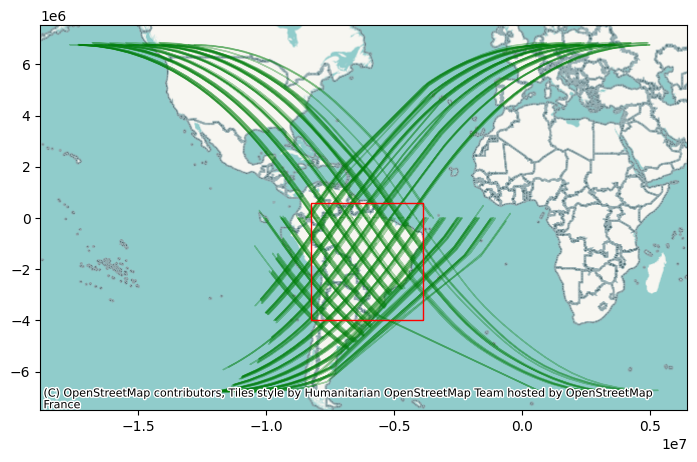

In [6]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits
ax = gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor="green")
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor="none", edgecolor="red")
# adding to contextily basemap
ctx.add_basemap(ax)


## 2. Searching for a polygonal area of interest (Option 2)

If an area of interest is already defined as a polygon, the polygon file (`geojson`, `shapefile` or `kml`) can be used to find overlapping GEDI L4A files. More details about this capability are described in [this page](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-shapefile).

For this tutorial, we will use the boundary of a northern states of Brazil, Amapá to search for the overlapping GEDI files. The boundary polygon is stored in a geojson file called `amapa.json` (shown in red polygon in the figure below).

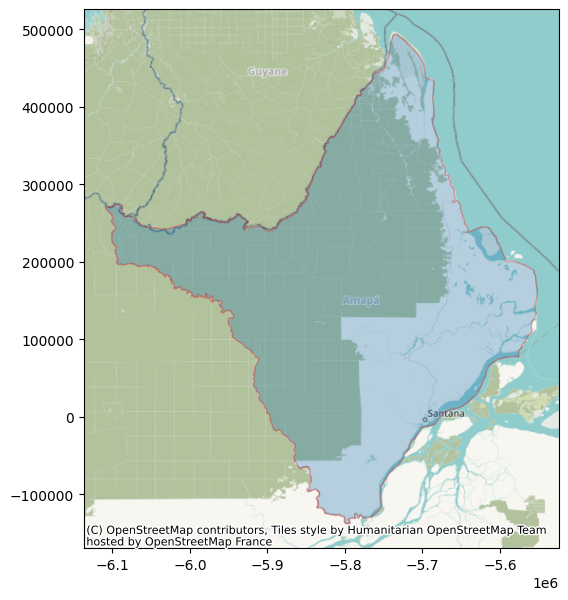

In [7]:
# Build file paths using pathlib.Path objects
polygon_features_path = Path(Path(os.getcwd()) / "polygons")
feat_path = Path(polygon_features_path / "amapa.json")
amapa = gpd.read_file(feat_path.as_posix())
amapa.geometry = amapa.geometry.apply(orient, args=(1,))
ax = amapa.to_crs(epsg=3857).plot(figsize=(7, 7), alpha=0.3, edgecolor="red")
ctx.add_basemap(ax)


In this example, we will search for all the GEDI L4A files available for the area using the CMR API.

In [8]:
doi = "10.3334/ORNLDAAC/2056"  # GEDI L4A DOI

# CMR API base url
cmrurl = "https://cmr.earthdata.nasa.gov/search/"

doisearch = cmrurl + "collections.json?doi=" + doi
response = requests.get(doisearch)
response.raise_for_status()
concept_id = response.json()["feed"]["entry"][0]["id"]

geojson = {
    "shapefile": ("amapa.geojson", amapa.geometry.to_json(), "application/geo+json")
}

page_num = 1
page_size = 2000  # CMR page size limit

granule_arr = []

while True:

    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id,
        "page_size": page_size,
        "page_num": page_num,
        "simplify-shapefile": "true",  # this is needed to bypass 5000 coordinates limit of CMR
    }

    granulesearch = cmrurl + "granules.json"
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
    granules = response.json()["feed"]["entry"]

    if granules:
        for g in granules:
            granule_url = ""
            granule_poly = ""

            # read file size
            granule_size = float(g["granule_size"])

            # reading bounding geometries
            if "polygons" in g:
                polygons = g["polygons"]
                multipolygons = []
                for poly in polygons:
                    i = iter(poly[0].split(" "))
                    ltln = list(map(" ".join, zip(i, i)))
                    multipolygons.append(
                        Polygon(
                            [
                                [float(p.split(" ")[1]), float(p.split(" ")[0])]
                                for p in ltln
                            ]
                        )
                    )
                granule_poly = MultiPolygon(multipolygons)

            # Get URL to HDF5 files
            for links in g["links"]:
                if (
                    "title" in links
                    and links["title"].startswith("Download")
                    and links["title"].endswith(".h5")
                ):
                    granule_url = links["href"]
            granule_arr.append([granule_url, granule_size, granule_poly])

        page_num += 1
    else:
        break


# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(["amapa", 0, amapa.geometry.item()])

# creating a pandas dataframe
l4adf = pd.DataFrame(
    granule_arr, columns=["granule_url", "granule_size", "granule_poly"]
)

# Drop granules with empty geometry
l4adf = l4adf[l4adf["granule_poly"] != ""]

print("Total granules found: ", len(l4adf.index) - 1)
print("Total file size (MB): ", l4adf["granule_size"].sum())


Total granules found:  846
Total file size (MB):  200959.95261500002


Now, we have stored the granule URLs and their bounding geometries into the pandas dataframe `l4adf`. The first few rows of the table look like the following.

In [9]:
# Set the geopandas properties to spread the column width and then  Print the first 5 rows of the dataframe
pd.set_option("display.max_colwidth", None)
l4adf.head()


,granule_url,granule_size,granule_poly
0,https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019112075017_O02026_02_T00059_02_002_02_V002.h5,201.574527,"MULTIPOLYGON (((-54.573288 0.012299, -52.4129715 3.0764229, -24.7008743 34.6037292, -21.2919388 37.1133156, -17.6403351 39.501297, -13.7217617 41.7480392, -9.5115891 43.8330536, -4.997684 45.7307587, -0.168958 47.4161758, 4.969233 48.8623505, 10.3956566 50.0432587, 16.0714436 50.933239, 21.9364147 51.5127716, 27.9135284 51.7665787, 29.6514969 51.77845, 29.6515675 51.8288116, 27.9113007 51.8169212, 21.9270039 51.5627937, 16.0552998 50.982563, 10.3734512 50.0915604, 4.9418492 48.9093857, -0.200616 47.4617577, -5.0327268 45.7747841, -9.5491982 43.8754883, -13.7612524 41.7888908, -17.6811352 39.5406151, -21.3335915 37.1511765, -24.7438469 34.6395874, -52.4541779 3.1054599, -54.6144638 0.041294, -54.573288 0.012299)))"
1,https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019112183906_O02033_03_T04182_02_002_02_V002.h5,307.588886,"MULTIPOLYGON (((-135.2212982 51.7785492, -129.2297058 51.6042175, -123.3301086 51.1028824, -117.6038284 50.2866249, -112.1102219 49.1744614, -106.8991318 47.7902641, -101.9948425 46.1589622, -97.4035263 44.3111458, -93.1221924 42.2692604, -89.1327438 40.059494, -85.4181747 37.703373, -81.952446 35.221302, -78.7102966 32.6311874, -75.6664734 29.9470596, -72.7967529 27.1846771, -70.0784378 24.3543892, -67.4904251 21.4679966, -65.0129089 18.5337734, -62.6274529 15.5608616, -60.3170166 12.556571, -58.0655251 9.5279865, -55.8580551 6.4810572, -53.6802979 3.4223969, -51.5186806 0.357733, -51.1656456 -0.14306, -51.124485 -0.114042, -51.4775047 0.386729, -53.6391029 3.4514699, -55.8167915 6.5103068, -58.0241585 9.5575199, -60.2755089 12.5864878, -62.5857773 15.5912724, -64.9710464 18.5647831, -67.4483948 21.4997234, -70.0362473 24.38694, -72.7544708 27.2181721, -75.624176 29.9816036, -78.6681366 32.6669121, -81.910614 35.2583046, -85.3769608 37.7417603, -89.0925293 40.0993652, -93.0834351 42.3106613, -97.3668671 44.3541412, -101.9609375 46.2035179, -106.8688812 47.8363495, -112.0845108 49.2219391, -117.5835571 50.3352928, -123.3161087 51.1524696, -129.22258 51.6543846, -135.2208252 51.8289108, -135.2212982 51.7785492)))"
2,https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019116060412_O02087_01_T03318_02_002_02_V002.h5,213.247052,"MULTIPOLYGON (((-88.2492523 -39.4172745, -84.618866 -37.0275269, -81.2282944 -34.5173759, -78.0530548 -31.9037991, -75.0679398 -29.201561, -72.2495346 -26.4236164, -69.5755386 -23.5814342, -67.0251083 -20.6850109, -64.5787201 -17.7428703, -62.2189369 -14.7635965, -59.9290962 -11.7549133, -57.693325 -8.7226744, -55.4969482 -5.6739898, -53.3258705 -2.6142671, -51.4833183 -0.000403, -51.5244904 0.028597, -53.3670578 -2.5852251, -55.5381889 -5.6447968, -57.7346611 -8.6932316, -59.970562 -11.725112, -62.2605629 -14.7333364, -64.6205292 -17.712038, -67.0670929 -20.6534958, -69.6176834 -23.5491276, -72.2918015 -26.3904018, -75.1102448 -29.1673222, -78.0952759 -31.8684254, -81.2702408 -34.4807549, -84.6602936 -36.9895515, -88.2901001 -39.3780327, -88.2492523 -39.4172745)))"
3,https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2019116060412_O02087_02_T03318_02_002_02_V002.h5,211.508106,"MULTIPOLYGON (((-51.4830933 -0.000085, -28.5628395 28.5524273, -25.6115913 31.2766533, -22.4737911 33.9157219, -19.1252766 36.4547539, -15.5399437 38.877388, -11.6939878 41.164444, -7.5656552 43.2941437, -3.134515 45.2439842, 1.610121 46.9891624, 6.6659741 48.5011253, 12.0186148 49.7552299, 17.6320133 50.7247162, 23.4523163 51.388752, 29.4066677 51.7308578, 32.7264595 51.7783127, 32.7264328 51.8286743, 29.4024887 51.7811508, 23.4410515 51.4386215, 17.6141777 50.7737999, 11.9949408 49.803215, 6.6373649 48.5477867, 1.577467 47.0343361, -3.1703169 45.28759, -7.6038351 43.3361511, -11.733

We can now plot the bounding geometries of the granules (shown with green lines in the figure below) using geopandas. The Amapá state is plotted in red color.

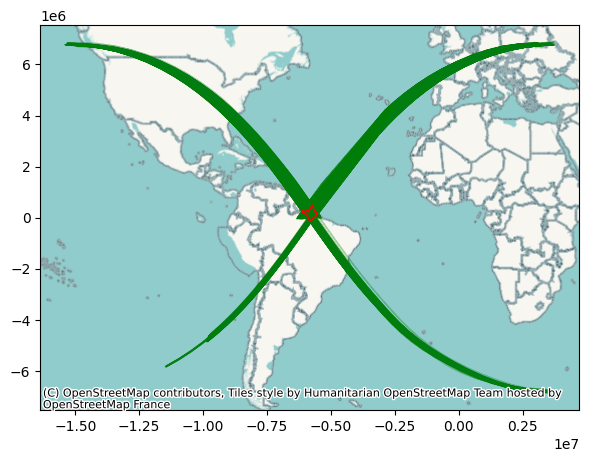

In [10]:
# creating a geopandas dataframe
gdf = gpd.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
# assiging CRS as WGS84
gdf.crs = "EPSG:4326"
# converting CRS to Web Mercator, the reference system of the contextily basemap
gdf_epsg3857 = gdf.to_crs(epsg=3857)
# plotting GEDI suborbits bounding geometry
ax = gdf_epsg3857[:-1].plot(figsize=(10, 5), alpha=0.3, edgecolor="green")
# plotting the bounding box (last row)
gdf_epsg3857[-1:].plot(ax=ax, facecolor="none", edgecolor="red")
# adding to contextily basemap
ctx.add_basemap(ax)


## 3. Downloading the files from Interplantary File System (IPFS)

With the granule file names, we can now download the GEDI L4A files from [IPFS](https://docs.ipfs.tech/concepts/what-is-ipfs/). With IPFS, files are stored on a distributed network of nodes, and the files are addressed by their content, not by their location. Each granule e.g. a file, is uniquely identified by a [content identifier](https://docs.ipfs.tech/concepts/content-addressing/#what-is-a-cid) (CID), which is a hash representing the content itself.

### How do I get the CID of the file?
You may be wondering how can we get the CID of the file if we know only the file name? That's where the [EASIER STAC API endpoint](https://stac.easierdata.info) comes in!  The API endpoint is based on the [stac-spec](https://stacspec.org/en), a structure for organizing and cataloging geospatial data and it's inherent metadata. We've extended additional metadata attributes for the GEDI L4A collection with the CID hash value for each file to easily identify and extract using the [ipfs-stac](https://github.com/easierdata/ipfs-stac) python library. 

## Accessing the EASIER STAC API endpoint
We start by creating a `client` object and passing in the STAC API endpoint we want to access and the the IP address and port of our Local IPFS node.

After the client object is created, we'll take a peek at the methods and properties available to us.


In [11]:

# Setting the properties for to connect to the Easier STAC Endpoint our our local IPFS gateway
# If necessary, change the values below to match your local IPFS gateway.
ipfs_gateway_ip = "127.0.0.1"
ipfs_gateway_port = "8081"
stac_collection_endpoint = "https://stac.easierdata.info"

# Creating our client object with the properties set above
easier_client = client.Web3(
    stac_endpoint=stac_collection_endpoint,
    local_gateway=ipfs_gateway_ip,
    gateway_port=ipfs_gateway_port,
)

_ = eu.print_properties(easier_client)


Properties and methods of <class 'ipfs_stac.client.Web3'> object:

_process                : <class 'NoneType'>
api_port                : <class 'int'>
forceLocalNode          : <class 'method'>
gateway_port            : <class 'str'>
getAssetFromItem        : <class 'method'>
getAssetsFromItem       : <class 'method'>
getCSVDataframeFromCID  : <class 'method'>
getFromCID              : <class 'method'>
local_gateway           : <class 'str'>
pinned_list             : <class 'method'>
searchSTACByBox         : <class 'method'>
searchSTACByBoxIndex    : <class 'method'>
stac_endpoint           : <class 'str'>
startDaemon             : <class 'method'>
uploadToIPFS            : <class 'method'>
writeCID                : <class 'method'>


### Querying the API endpoint

Now that we have the client object, we can query the API endpoint and get the metadata of the GEDI L4A collection. We'll pass in the bounding box from [Option 2](#2-searching-for-a-polygonal-area-of-interest-option-2).

| Note: We are using the bounding box, not the polygon coordinates to query the API endpoint. |

In [12]:
collection_name = "GEDI_L4A_AGB_Density_V2_1_2056.v2.1"
granule_results = easier_client.searchSTACByBox(
    bbox=bound,
    collections=collection_name,
)

print(f"Total granules found from our search: {len(granule_results.items)}\n")
eu.print_granule_properties(granule_results.items[0])

# Select the asset key that contains the data we are interested in
selected_asset_key = [
    key for key in granule_results.items[0].assets.keys() if "gov/protected" in key
][0]

# Print the selected asset key
granule_results.items[0].assets[f"{selected_asset_key}"]


Total granules found from our search: 846

Property Name     Type             Value
----------------------------------------------------------------------------------------------------------------------
type              <class 'str'>    Feature
stac_version      <class 'str'>    1.0.0
id                <class 'str'>    GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2023075201011_O24115_02_T08796_02_003_01_V002.h5
properties        <class 'dict'>   
geometry          <class 'dict'>   
links             <class 'list'>   
assets            <class 'dict'>   
bbox              <class 'list'>   
stac_extensions   <class 'list'>   
collection        <class 'str'>    GEDI_L4A_AGB_Density_V2_1_2056.v2.1
----------------------------------------------------------------------------------------------------------------------


For our purpose, we want to take a look at the `assets` property of the granule. Each item in `assets` contains 
additional properties like the file name, type and what locations the dat

<Asset href=https://data.ornldaac.earthdata.nasa.gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2023075201011_O24115_02_T08796_02_003_01_V002.h5>

# Ask and ye shall receive!

Typically, you would navigate to a source location, a _**url address**_ to access and retrieve your content from a centralized location. Instead, we'll be announcing our request on the IPFS network.

First, we need to know what it is that we want? While we know the names of the granules which are needed, the *filenames* themselves is not enough to retrieve content from a decentralized network. What we need is the CID of the file, known as a content identifier, that forms a hash value based on the content itself. 

The SpatioTemporal Asset Catalogs [STAC](https://stacspec.org/en/) is a specification to describe geospatial information and we've extended the spec on the [Easier STAC endpoint](https://stac.easierdata.info) to supply the CID's for geospatial content that's been prepared for decentralized storage.

You may have already noticed the CID values when you were exploring the `alternate` sources property above. Let's grab the CID values for the granules we want to fetch from IPFS. Using the `getAssetFromItem` method, we can pass in the collection of `items` from our query and the `asset_key` we want to source for the CID.


In [13]:
granlue_payload = eu.get_cid_payload(granule_results)
# print the first item from the dictionary granule_payload
list(granlue_payload.items())[0]


('GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2023075201011_O24115_02_T08796_02_003_01_V002.h5',
 {'cid': 'bafybeihnmpauukdsaoa45n2visfhrbmqxufe2w5uo37p3ofb5xwsofv6di',
  'item': <Item id=GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2023075201011_O24115_02_T08796_02_003_01_V002.h5>,
  'asset_key': 'gov/protected/gedi/GEDI_L4A_AGB_Density_V2_1/data/GEDI04_A_2023075201011_O24115_02_T08796_02_003_01_V002'})

Let's grab the first granule from IPFS and then take a look at the `METADATA` group to view some of the attributes.

In [14]:
for granule in granule_results.items[:1]:
    # Select the asset key that contains the data we are interested in
    selected_asset_key = [
        key for key in granule.assets.keys() if "gov/protected" in key
    ][0]
    fetched_asset = easier_client.getAssetFromItem(
        granule, selected_asset_key, fetch_data=True
    )

print(eu.print_granule_metadata(easier_client, fetched_asset.cid))




Table 1. Attributes and discription from `METADATA` group


attribute,description
PGEVersion,003
VersionID,01
abstract,The GEDI L4A standard data product contains predictions of aboveground biomass density within each laser footprint.
characterSet,utf8
creationDate,2023-05-22T14:17:19.021109Z
credit,"The software that generates the L4A product was implemented at the Department of Geographical Sciences at the University of Maryland (UMD), in collaboration with the GEDI Science Data Processing System at the NASA Goddard Space Flight Center (GSFC) in Greenbelt, Maryland and the Institute at Brown for Environment and Society at Brown University."
fileName,GEDI04_A_2023075201011_O24115_02_T08796_02_003_01_V002.h5
gedi_l4a_githash,8145a32755ee6f4f58a2315ee244450f846d33d9
language,eng
originatorOrganizationName,GSFC GEDI-SDPS > GEDI Science Data Processing System and University of Maryland


None


Now that the content has been fetched, let's pin the content to our local IPFS node. Pinning is a way to tell the IPFS network to keep a copy of the content on your local node. This is useful to ensure that the content is always available and not marked for garbage collection. You can find more details on how IPFS manages storage on your local node [here](https://docs.ipfs.io/concepts/persistence/).


In [15]:
fetched_asset.pin()


Data for asset has not been fetched yet. Fetching now...
⠙ Fetching bafybeihnmpauukdsaoa45n2visfhrbmqxufe2w5uo37p3ofb5xwsofv6di - 0/20168 

c:\github\client_projects\umd\gedi_tutorials\.venv\Lib\site-packages\yaspin\core.py:128: UserWarning: color, on_color and attrs are not supported when running in jupyter
  self._color = self._set_color(color) if color else color


✅  Fetching bafybeihnmpauukdsaoa45n2visfhrbmqxufe2w5uo37p3ofb5xwsofv6di - 201683 
Data pinned successfully


Let us continue to download the rest of the granules from IPFS and pin them on our local node.

In [ ]:
for granule in granule_results.items:
    # Select the asset key that contains the data we are interested in
    selected_asset_key = [
        key for key in granule.assets.keys() if "gov/protected" in key
    ][0]
    fetched_asset = easier_client.getAssetFromItem(
        granule, selected_asset_key, fetch_data=True
    )
    fetched_asset.pin()
